<a href="https://colab.research.google.com/github/goranagojic/paralelno-racunarstvo/blob/main/PR_termin8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Paralelno računarstvo - Vežba 8

*   Zadatak 1 - Sabiranje vektora (pokazni)
*   Zadatak 2 - Množenje matrice skalarom (pokazni)
*   Zadatak 3 - Zamućenje slike

## Preduslovi
Pre nego započnete implementaciju zadataka, **obavezno** izvršite kod iz ćelije ispod. Kod će:
- skinuti kompresovanu biblioteku `libwb` koja se koristi u zadacima i raspakovati je na putanju /usr/local/libwb.
- skinuti set podataka za testiranje rešenja zadatka i raspakovati ga na putanju /home/cuda

In [ ]:
%%bash

######################### PREUZMI I PODESI libwb ##############################
# preuzmi libwb.zip ako već nije preuzet
[[ -f libwb.zip ]] || wget -O libwb.zip "https://drive.google.com/u/0/uc?id=1-j31qXJJOBFKuNc4qzTjTU-Gji8HARh0&export=download"

# otpakuj
unzip -oqqd /usr/local libwb.zip


################### PREUZMI I PODESI set za testiranje ########################
# preuzmi dataset.zip ako vec nije preuzet
[[ -f dataset.zip ]] || wget -O dataset.zip "https://drive.google.com/u/0/uc?id=1gfQ9bMVWBsIt2Shqexeu0FbSinSy9-sK&export=download"

# otpakuj u direktorijum u kojem ce se nalaziti izvrsna datoteka resenja
mkdir -p /home/cuda/
unzip -oqqd /home/cuda/ dataset.zip

Po završetku prethodne ćelije, možete pokrenuti narednu koja proverava da li `libwb` i `dataset` direktorijumi postoje na predviđenim putanjama. Ukoliko je sve u redu, obe naredbe će ispisati absolutne putanje do direktorijuma. U suprotnom će prijaviti da jedan ili oba direktorijuma nisu pronađena. U tom slučaju treba da se vratite na log prethodne ćelije i potražite gde je došlo do greške.

In [ ]:
%%bash

ls -d /usr/local/libwb/
ls -d /home/cuda/

## [Opciono] Deinstalacija preduslova
Izvršavanjem ćelije ispod brišete instaliranu biblioteku `libwb` i set podataka. Izvršite ovu ćeliju samo ako želite da resetujete instalaciju kako biste reinstalirali preduslove.

In [ ]:
%%bash

# obrisi libwb biblioteku
[[ -d /usr/local/libwb ]] && rm -r /usr/local/libwb/ && echo "Obrisana libwb biblioteka."
[[ -f libwb.zip ]] && rm libwb.zip && echo "Obrisana libwb.zip arhiva."

# obrisi set podataka za testiranje
[[ -d /home/cuda/dataset ]] && rm -r /home/cuda/dataset && echo "Obrisan set podataka."
[[ -f dataset.zip ]] && rm dataset.zip && echo "Obrisana dataset.zip arhiva."

## Zadatak 1 - Sabiranje vektora

Imlementacija CUDA kernela za sabiranje dva vektora razlomljenih vrednosti.

In [ ]:
%%writefile /home/cuda/vectoradd.cu

#include <stdio.h>
#include <assert.h>
#include <cuda.h>

// U videu postoji greska u ovom makrou, ovde je greska ispravljena
#define cudaCheckError(stmt) {           \
    cudaError_t err = stmt;              \
    if (err != cudaSuccess) {            \
        printf("CUDA failure %s:%d: '%s'\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
        exit(1);                         \
    }                                    \
}

__global__
void vecAddKernel(float *A_d, float* B_d, float *C_d, int n) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
        C_d[i] = A_d[i] + B_d[i];
}
                
void vectorAdd(float *A, float *B, float *C, int n) {
    int size = n * sizeof(float);
    float *A_d, *B_d, *C_d;

    // 1. Alokacija memorije uredjaja za nizove A, B i C
    cudaCheckError(cudaMalloc((void **) &A_d, size));
    cudaCheckError(cudaMalloc((void **) &B_d, size));
    cudaCheckError(cudaMalloc((void **) &C_d, size));

    // 2. Kopiranje ulaznih nizova u memoriju uredjaja
    cudaCheckError(cudaMemcpy(A_d, A, size, cudaMemcpyHostToDevice));
    cudaCheckError(cudaMemcpy(B_d, B, size, cudaMemcpyHostToDevice));

    // 3. Poziv kernela
    // vecAddKernel<<<ceil(n / 256.0), 256>>>(A_d, B_d, C_d, n);
    dim3 dimGrid(n / 256, 1, 1);
    if (n % 256) dimGrid.x++;
    dim3 dimBlock(256, 1, 1);
    vecAddKernel<<<dimGrid, dimBlock>>>(A_d, B_d, C_d, n);
    cudaDeviceSynchronize();

    // 4. Transfer rezultujuceg vektora iz memorije uredjaja u memoriju domacina
    cudaCheckError(cudaMemcpy(C, C_d, size, cudaMemcpyDeviceToHost));

    // 5. Dealokacija memorije zauzete na GPU
    cudaCheckError(cudaFree(A_d));
    cudaCheckError(cudaFree(B_d));
    cudaCheckError(cudaFree(C_d));
}


int main() {

    int n = 1025;
    float *A = (float *) calloc(n, sizeof(float));  // niz A ce imati sve elemente 0
    float *B = (float *) malloc(n * sizeof(float));
    float *C = (float *) malloc(n * sizeof(float));

    for (int i = 0; i < n; i++) B[i] = 1;           // niz B ce imati sve elemente 1

    vectorAdd(A, B, C, n);

    // ako neki od elemenata vektora C nije 1, program ce biti terminisan
    for (int i = 0; i < n; i++) assert(C[i] == 1);

    free(A);
    free(B);
    free(C);

    return 0;
}


### Kompajliranje izvornog koda
Pokrenite komandu u ćeliji ispod kako biste kompajlirali rešenje.

In [ ]:
%%bash

cd /home/cuda
nvcc vectoradd.cu -o vectoradd \
  -I /usr/local/libwb/ \
  -L /usr/local/libwb/lib \
  -lwb -lcuda

### [Opciono] Provera da li postoji izvrsna datoteka

In [ ]:
![[ -f /home/cuda/vectoradd ]] && echo "Postoji." || echo "Ne postoji."

### Pokretanje rešenja nad jednim primerom

In [ ]:
%%bash

cd /home/cuda
LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./vectoradd

## Zadatak 2 - Množenje matrice skalarom

In [ ]:
%%writefile /home/cuda/picturekernel.cu

#include <wb.h>

#define IMAGE_WIDTH 1024
#define IMAGE_HEIGHT 768


// CUDA C kernel za množenje matrice sa 2
__global__ void PictureKernel(float *d_Pin, float *d_Pout, int height, int width) {

    const int Row = blockDim.y * blockIdx.y + threadIdx.y;
    const int Col = blockDim.x * blockIdx.x + threadIdx.x;

    if (Row < height && Col < width) {
        d_Pout[Row * width + Col] = 2.0 * d_Pin[Row * width + Col];
    }
}

// Funkcija za inicijalizaciju matrice na zadatu vrednost
void init_matrix(float *matrix, int width, int height, float value) {
    for (int i = 0; i < width * height; i++) {
        matrix[i] = value;
    }
}


// Funkcija za proveru 
void check_matrix(float *matrix, int width, int height, float expected_value) {
    char isCorrect = 1;
    for (int i = 0; i < width * height; i++) {
        if (matrix[i] != expected_value) {
            isCorrect = 0;
            printf("Prva vrednost različita od 2 se nalazi na poziciji %d (vrednost: %f)\n.",
                   i, matrix[i]);
            break;
        }
    }

    if (isCorrect) {
        printf("Solution is correct.\n");
    } else {
        printf("Solution is NOT correct.\n");
    }
}


int main(int argc, char *argv[]) {
    int imageWidth = IMAGE_WIDTH;
    int imageHeight = IMAGE_HEIGHT;
    float *hostInputImageData;
    float *hostOutputImageData;
    float *deviceInputImageData;
    float *deviceOutputImageData;
    float value = 1.0;

    // alokacija prostora za matrice u memoriji domacina
    hostInputImageData = (float *) malloc(sizeof(float) * imageWidth * imageHeight);
    hostOutputImageData = (float *) malloc(sizeof(float) * imageWidth * imageHeight);

    // inicijalizacja elemenata ulazne matrice na zadatu vrednost
    init_matrix(hostInputImageData, imageWidth, imageHeight, value);

    wbTime_start(GPU, "Doing GPU Computation (memory + compute)");

    // alokacija prostora za matrice u memoriji uredjaja
    wbTime_start(GPU, "Doing GPU memory allocation");
    cudaMalloc((void **)&deviceInputImageData,
               imageWidth * imageHeight * sizeof(float));
    cudaMalloc((void **)&deviceOutputImageData,
               imageWidth * imageHeight * sizeof(float));
    wbTime_stop(GPU, "Doing GPU memory allocation");
  
    // kopiranje sadrzaja ulazne matrice iz memorije domacina u memoriju uredjaja
    wbTime_start(Copy, "Copying data to the GPU");
    cudaMemcpy(deviceInputImageData, hostInputImageData,
               imageWidth * imageHeight * sizeof(float),
               cudaMemcpyHostToDevice);
    wbTime_stop(Copy, "Copying data to the GPU");

    ///////////////////////////////////////////////////////
    // Priprema i poziv CUDA kernela
    wbTime_start(Compute, "Doing the computation on the GPU");

    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil((float) imageWidth / 16), ceil((float) imageHeight / 16), 1);
    PictureKernel<<<dimGrid, dimBlock>>>(deviceInputImageData, deviceOutputImageData, imageHeight, imageWidth);

    wbTime_stop(Compute, "Doing the computation on the GPU");
    ///////////////////////////////////////////////////////

    // kopiranje sadrzaja rezultujuce matrice iz memorije uredjaja u memoriju domacina
    wbTime_start(Copy, "Copying data from the GPU");
    cudaMemcpy(hostOutputImageData, deviceOutputImageData,
               imageWidth * imageHeight * sizeof(float),
               cudaMemcpyDeviceToHost);
    wbTime_stop(Copy, "Copying data from the GPU");
  
    wbTime_stop(GPU, "Doing GPU Computation (memory + compute)");

    // provera ispravnosti rezultata
    check_matrix(hostOutputImageData, imageWidth, imageHeight, 2.0);
  
    // oslobadjanje prostora alociranog u memoriji uredjaja
    cudaFree(deviceInputImageData);
    cudaFree(deviceOutputImageData);

    // oslobadjanje prostora alociranog u memoriji domacina
    free(hostInputImageData);
    free(hostOutputImageData);
  
    return 0;
}

### Kompajliranje izvornog koda
Pokrenite komandu u ćeliji ispod kako biste kompajlirali rešenje.

In [ ]:
%%bash

cd /home/cuda
nvcc picturekernel.cu -o picturekernel \
  -I /usr/local/libwb/ \
  -L /usr/local/libwb/lib \
  -lwb -lcuda

### [Opciono] Provera da li postoji izvršna datoteka

In [ ]:
![[ -f /home/cuda/picturekernel ]] && echo "Postoji." || echo "Ne postoji."

### Pokretanje rešenja

Svi elementi ulazne matrice su podrazumevano inicijalizovani na razlomljenu vrednost 1. Nakon izvršavanja kernela, svi elementi matrice će biti 2.

In [ ]:
%%bash

cd /home/cuda
LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./picturekernel

## Zadatak 3 - Zamućenje slike

Implementirati CUDA C kernel za zamućivanje ulazne slike. Ulazna slika je uvek u nijansama sive i svaki piksel slike je predstavljen jednom vrednošću intenziteta boje. Kada se učita u memoriju, slika je predstavljena matricom čiji je svaki piksel jedan element matrice. Ulazna matrica koja predstavlja ulaznu sliku je linearizovana vrstu po vrstu.

Na osnovu ulazne matrice je potrebno sračunati izlaznu matricu koja predstavlja zamućenu sliku. Drugim rečima, za svaki element ulazne matrice je potrebno sračunati novu vrednost korespodentnog elementa izlazne matrice. Nova vrednost elementa se računa kao aritmetička sredina vrednosti trenutno posmatranog elementa ulazne matrice i njegovih $N \cdot N-1$ susednih elemenata. Na slici su prikazana dva primera računanja elemenata rezultujuće matrice. Prvi primer (element čiji su susedi obeleženi plavom bojom) prikazuje kako treba sračunati rezultujuću vrednost kada su susedi posmatranog elementa unutar matrice. U drugom slučaju (element čiji su susedi obeleženi žutom bojom) rezultat računanja se formira samo na osnovu vrednosti susednih elemenata unutar ulazne matrice.

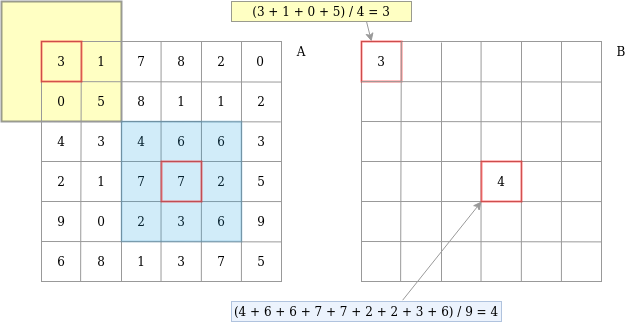

Učitavanje ulazne slike, prebacivanje slike na uredjaj, prebacivanje
rezultata sa uredjaja i čuvanje rezultata je implementirano u datoj
postavci zadatka. Potrebno je dopuniti postavku implementacijom:

-   kernela za zamućenje slike konvolucijom i
-   pozivom kernela na za to naznačenim mestima

Celokupno rešenje treba da se nađe u ćeliji ispod.

In [ ]:
%%writefile /home/cuda/imageblur.cu

#include <wb.h>

#define wbCheck(stmt)                                                     \
  do {                                                                    \
    cudaError_t err = stmt;                                               \
    if (err != cudaSuccess) {                                             \
      wbLog(ERROR, "Failed to run stmt ", #stmt);                         \
      wbLog(ERROR, "Got CUDA error ...  ", cudaGetErrorString(err));      \
      return -1;                                                          \
    }                                                                     \
  } while (0)

#define BLUR_SIZE 5

// TODO implementirati kernel

int main(int argc, char *argv[]) {
  wbArg_t args;
  int imageWidth;
  int imageHeight;
  char *inputImageFile;
  wbImage_t inputImage;
  wbImage_t outputImage;
  float *hostInputImageData;
  float *hostOutputImageData;
  float *deviceInputImageData;
  float *deviceOutputImageData;

  args = wbArg_read(argc, argv);                        // parsiranje ulaznih argumenata

  inputImageFile = wbArg_getInputFile(args, 0);

  inputImage = wbImport(inputImageFile);

  // Ulazna slika je u nijansama sive i ima samo jedan kanal
  // sto znaci da su dimenzije ucitane slike imageWidth x imageHeight x 1
  imageWidth  = wbImage_getWidth(inputImage);           // sirina slike (broj kolona)
  imageHeight = wbImage_getHeight(inputImage);          // visina slike (broj vrsta)

  // Slika je monohromatska i sadrzi samo jedan kanal
  outputImage = wbImage_new(imageWidth, imageHeight, 1);

  hostInputImageData  = wbImage_getData(inputImage);
  hostOutputImageData = wbImage_getData(outputImage);

  wbTime_start(GPU, "Doing GPU Computation (memory + compute)");

  wbTime_start(GPU, "Doing GPU memory allocation");     // alokacija memorije na GPU za
  cudaMalloc((void **)&deviceInputImageData,            // 1) ulaznu sliku (sliku koju treba zamutiti)
             imageWidth * imageHeight * sizeof(float));
  cudaMalloc((void **)&deviceOutputImageData,           // 2) izlaznu sliku (zamucena slika)
             imageWidth * imageHeight * sizeof(float));
  wbTime_stop(GPU, "Doing GPU memory allocation");

  wbTime_start(Copy, "Copying data to the GPU");
  cudaMemcpy(deviceInputImageData, hostInputImageData,  // kopiranje ulazne slike na GPU
             imageWidth * imageHeight * sizeof(float),
             cudaMemcpyHostToDevice);
  wbTime_stop(Copy, "Copying data to the GPU");

  wbTime_start(Compute, "Doing the computation on the GPU");

  wbTime_stop(Compute, "Doing the computation on the GPU");

  ///////////////////////////////////////////////////////

  // TODO ovde pozvati kernel

  ///////////////////////////////////////////////////////

  wbTime_start(Copy, "Copying data from the GPU");     // kopiranje izlazne slike iz memorije GPU u RAM
  cudaMemcpy(hostOutputImageData, deviceOutputImageData,
             imageWidth * imageHeight * sizeof(float),
             cudaMemcpyDeviceToHost);
  wbTime_stop(Copy, "Copying data from the GPU");

  wbTime_stop(GPU, "Doing GPU Computation (memory + compute)");

  wbSolution(args, outputImage);                      // poredjenje dobijenog resenja sa tacnim 
                                                      // ako je zadata opcija -e <slika> pri pozivu programa

  cudaFree(deviceInputImageData);
  cudaFree(deviceOutputImageData);

  wbImage_delete(outputImage);
  wbImage_delete(inputImage);

  return 0;
}

### Kompajliranje izvornog koda
Pokrenite komandu u ćeliji ispod kako biste kompajlirali rešenje.

In [ ]:
%%bash

cd /home/cuda
nvcc imageblur.cu -o imageblur \
  -I /usr/local/libwb/ \
  -L /usr/local/libwb/lib \
  -lwb -lcuda

### [Opciono] Provera da li postoji izvrsna datoteka

In [ ]:
![[ -f /home/cuda/imageblur ]] && echo "Postoji." || echo "Ne postoji."

### Pokretanje rešenja nad jednim primerom

In [ ]:
%%bash

cd /home/cuda
LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./imageblur \
  -i dataset/0/input.ppm \
  -e dataset/0/output.ppm \
  -o output.ppm \
  -t image

### Pokretanje rešenja nad svim primerima

Nakon uspešnog testiranja rešenja na jednom primeru, možete pokrenuti i testiranje rešenja na svim primerima iz seta podataka.

In [ ]:
%%bash

cd /home/cuda

n=$(ls -dl dataset/* | wc -l)

for (( i=0; i<$n; i=i+1 ))
do
  echo "Testiram primer $i."
  echo "-------------------"
  LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./imageblur \
      -i dataset/$i/input.ppm \
      -e dataset/$i/output.ppm \
      -o output.ppm \
      -t image
  echo ""
done